In [1]:
from datasets import load_dataset

"""
я использую этот датасет, потому что датасет, который был представлен в примере
к тестовому заданию содержит данные в zip из-за чего после их загрузки через
load_dataset они достаются по 1 из архива, что крайне медленно,
возможно эту проблему можно как-то решить,
но есть и вторая - лейблы не схватываются автоматически

в этом датасете изображения в чб формате
"""

hf_dataset = load_dataset('priyank-m/MJSynth_text_recognition', split='train', cache_dir='./datasets')

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

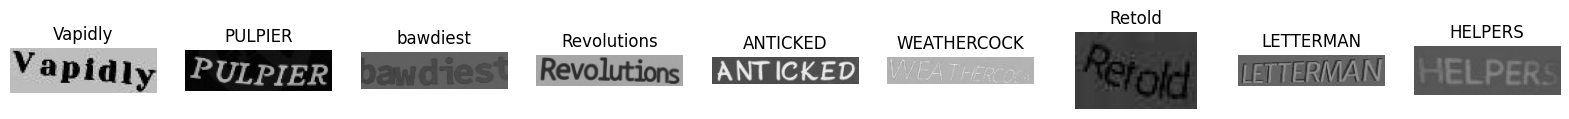

In [2]:
# выведем несколько случайных изображений с лейблами из датасета, чтобы знать какого рода данные в нем

import matplotlib.pyplot as plt
import random

def image_visualize(dataset, count: int = 6):
    fig, axes = plt.subplots(1, count, figsize=(20, 1))
    for ax in axes:
        idx = random.randint(0, len(dataset))
        image = dataset[idx]['image']
        text = dataset[idx]['label']
        ax.imshow(image)
        ax.set_title(text)
        ax.axis(False)

image_visualize(hf_dataset, 9)

In [23]:
import torch

# Параметры изображений
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.0002
BETAS = (0.5, 0.999)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

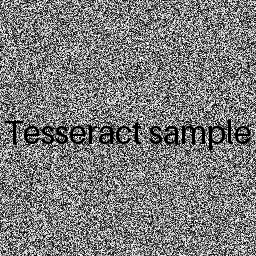

In [24]:
# код для генерации изображений с текстом по середине

import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np


def generate_image_with_text(w: int = IMAGE_WIDTH, h: int = IMAGE_HEIGHT, text: str = "Tesseract sample") -> Image.Image:
    """
    Функция для генерации изображений с заданными текстом
    w - ширина
    h - высота
    text - текст на изображении
    """
    random_noise = np.random.randint(0, 256, (h, w), dtype=np.uint8)
    img = Image.fromarray(random_noise, mode='L')
    img_draw = ImageDraw.Draw(img)
    font = ImageFont.load_default(32)
    text_bbox = img_draw.textbbox((0, 0), text, font=font)
    text_w = text_bbox[2] - text_bbox[0]
    text_h = text_bbox[3] - text_bbox[1]
    x = (w - text_w) // 2
    y = (h - text_h) // 2
    img_draw.text((x, y), text, font=font)
    img = img.convert("RGB")
    return img

img = generate_image_with_text()
img

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
# Архитектура cgan по примеру из https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
        
import torch
import torch.nn as nn

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)



class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [26]:
from torch.utils.data import Dataset

class TextImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        real_image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        
        # Генерация изображения с текстом
        generated_image = generate_image_with_text(text=label)
        
        if self.transform:
            real_image = self.transform(real_image)
            generated_image = self.transform(generated_image)
        
        return generated_image, real_image

In [27]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


dataset = TextImageDataset(hf_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
from torch.autograd import Variable

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

generator = GeneratorUNet().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=BETAS)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=BETAS)

adversarial_loss = nn.BCELoss()

torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256])


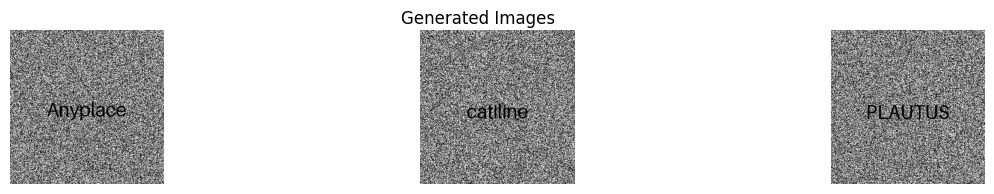

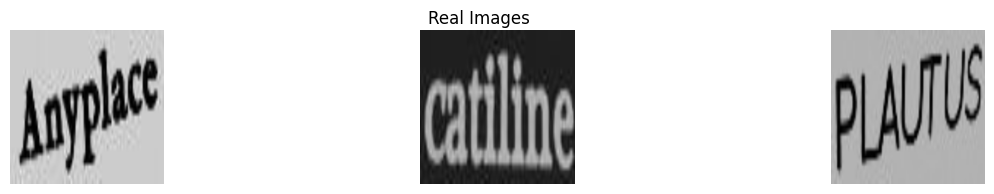

In [29]:
# отобразим парочку изображений с батча 

def show_images(images, title="Images"):
    """
    Визуализация батча изображений.
    images: Тензор изображений (batch_size, channels, height, width).
    title: Заголовок для отображения.
    """
    # формат подходящий для matplotlib
    images = images.cpu().numpy()  
    images = images.transpose(0, 2, 3, 1) 
    
    # denorm
    images = (images + 1) / 2 
    images = images.clip(0, 1)  

    fig, axes = plt.subplots(1, len(images), figsize=(15, 2))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()

for i, (generated_images, real_images) in enumerate(dataloader):
    print(generated_images.shape)
    print(real_images.shape)
    
    generated_images = generated_images.to(DEVICE)[:3]
    real_images = real_images.to(DEVICE)[:3]

    #test generator
    gen_imgs = generator(generated_images)

    show_images(generated_images, title="Generated Images")
    
    show_images(real_images, title="Real Images")
    
    break 

In [30]:
from torchvision.utils import save_image

for epoch in range(NUM_EPOCHS):
    for i, (generated_imgs, real_imgs) in enumerate(dataloader):

        batch_size = real_imgs.shape[0]

        # Переводим данные на устройство (GPU или CPU)
        real_imgs = Variable(real_imgs.to(DEVICE))
        generated_imgs = Variable(generated_imgs.to(DEVICE))

        # Метки для обучения (1 - реальные изображения, 0 - сгенерированные)
        valid = Variable(torch.ones(batch_size, 1, 1, 1).to(DEVICE), requires_grad=False)
        fake = Variable(torch.zeros(batch_size, 1, 1, 1).to(DEVICE), requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Генерируем изображения
        gen_imgs = generator(generated_imgs)  # Преобразуем сгенерированные OpenCV-рендеры

        # Оцениваем способность генератора обмануть дискриминатор
        g_loss = adversarial_loss(discriminator(gen_imgs, real_imgs), valid)

        # Обратное распространение ошибки
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Оценка реальных изображений
        real_loss = adversarial_loss(discriminator(real_imgs, real_imgs), valid)
        
        # Оценка сгенерированных изображений
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), real_imgs), fake)

        # Итоговый лосс дискриминатора
        d_loss = (real_loss + fake_loss) / 2

        # Обратное распространение ошибки
        d_loss.backward()
        optimizer_D.step()

        # Логирование прогресса
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, NUM_EPOCHS, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        # Сохранение изображений каждые 100 итераций
        batches_done = epoch * len(dataloader) + i
        if batches_done % 100 == 0:
            save_image(gen_imgs.data[:25], "images/generated_%d.png" % batches_done, nrow=5, normalize=True)
            save_image(real_imgs.data[:25], "images/real_%d.png" % batches_done, nrow=5, normalize=True)


ValueError: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1, 16, 16])) is deprecated. Please ensure they have the same size.